# Decomposing paired chain restriction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyrepseq as prs

plt.style.use('tcrspace.mplstyle')

In [2]:
# whether to also match V and J genes for exact coincidences
match_genes = False

In [3]:
d = pd.read_csv('data/dash_human.csv')
if match_genes:
    d['j_a_gene'].fillna(value='na', inplace=True)
    d['cdr3_a_aa'] = d['v_a_gene'] + d['cdr3_a_aa'] + d['j_a_gene']
    d['cdr3_b_aa'] = d['v_b_gene'] + d['cdr3_b_aa'] + d['j_b_gene']
d['cdr3s'] = d['cdr3_a_aa'] + d['cdr3_b_aa']

In [4]:
# get a background coincidence frequency array
chains = ['alpha', 'beta']
data_directory ='data/minervina/'
pcback = {}
for chain in chains:
    df_back = pd.read_csv(data_directory + '{chain}/W_F1_2018_{chain}.txt.gz'.format(chain=chain), sep='\t')
    df_back = df_back[df_back['aaSeqCDR3'].apply(prs.isvalidcdr3)]
    if match_genes:
        df_back['aaSeqCDR3'] = df_back['bestVGene'] + df_back['aaSeqCDR3'] + df_back['bestJGene']
    pcback[chain] = prs.pc(df_back['aaSeqCDR3'])
pcback['both'] = pcback['alpha']*pcback['beta']

In [5]:
chis = []
for epitope, dfg in d.groupby('epitope'):
    chib = prs.pc(d[d['epitope']==epitope]['cdr3_b_aa'])/pcback['beta']
    chia = prs.pc(d[d['epitope']==epitope]['cdr3_a_aa'])/pcback['alpha']
    chiab = prs.pc(d[d['epitope']==epitope]['cdr3s'])/pcback['both']
    chis.append([epitope, (chia), (chib), (chiab)])
chis = pd.DataFrame(chis, columns=['epitope', 'pca', 'pcb', 'pcab'])

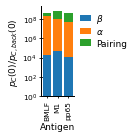

In [6]:
fig, ax = plt.subplots(figsize=(1.6, 2.0))

plt.bar(chis['epitope'], chis['pcb'], label=r"$\beta$")
plt.bar(chis['epitope'], chis['pca']*chis['pcb'], label=r'$\alpha$', zorder=-1)
plt.bar(chis['epitope'], chis['pcab'], label='Pairing', zorder=-2)

plt.xticks(rotation=90)
ax.set_yscale('log')
ax.set_ylim(1e0, 2e9)
ax.set_yticks(10**np.arange(0, 10, 2))
ax.set_xlabel("Antigen")
ax.set_ylabel('$p_C(0)/p_{C,back}(0)$')
fig.tight_layout(rect=(0.0, 0.0, 0.75, 1.0))
ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
fig.savefig('figures/figure4.svg')

In [7]:
chis

,epitope,pca,pcb,pcab
0,BMLF,9127.642299,19969.600824,4.168514e+08
1,M1,2012.393578,44308.891950,5.756547e+08
2,pp65,3758.440947,12248.511290,4.462762e+08


In [8]:
chis_mean = chis[['pca', 'pcb', 'pcab']].mean()
chis_mean

pca     4.966159e+03
pcb     2.550900e+04
pcab    4.795941e+08
dtype: float64

In [9]:
chis['pcb']/chis['pca']

0     2.187816
1    22.018005
2     3.258934
dtype: float64

In [10]:
chis_mean['pcb']/chis_mean['pca']

5.1365656346846515